# ***AMATRICE-VISSO-NORCIA 2016-2017*** seismic sequence (Central Appennines)

#### The aim is to ***create a seismic catalog using new artificial intelligence methods***, particularly ***PhaseNet*** (Zhu et al., 2019) and the ***Seisbench*** platform, which contains training datasets and other deep learning models for picking.

##### Let's start with the last task:
##### Combine the PhaseNet picking to built a catalog.
##### We'll use Seisbench and ***GaMMA*** (Zhu et al., 2022) that is an unsupervised machine-learnig algorith for clustering.

##### See documentation at: https://github.com/seisbench/seisbench

In [1]:
#import libraries
import obspy
from obspy.clients.fdsn import Client
from obspy import UTCDateTime
from obspy.core.utcdatetime import UTCDateTime
from obspy.signal.filter import bandpass
from obspy.geodetics import gps2dist_azimuth
from pyproj import CRS, Transformer
import pandas as pd
import numpy as np
from collections import Counter
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import math
import os
import re

from gamma.utils import association
import seisbench.models as sbm

sns.set(font_scale=1.2)
sns.set_style("ticks")

In [2]:
#parameters
training="instance"
year=2016

In [3]:
output_dir = "/Users/rossella.fonzetti/WORK/EGU2025/TUTORIAL_EPOS/TEST_AMATRICE/output/catalog"
os.makedirs(output_dir, exist_ok=True)

# GaMMA parameters and coordinate convesion
wgs84 = CRS.from_epsg(4326) 
utm33n = CRS.from_epsg(32633)
transformer = Transformer.from_crs(wgs84, utm33n, always_xy=True) #Define UTC area
config = {}
config["dims"] = ['x(km)', 'y(km)', 'z(km)']
config["use_dbscan"] = True
config["use_amplitude"] = False
config["x(km)"] = (250, 600)
config["y(km)"] = (4100, 5000)
config["z(km)"] = (0, 150)
config["vel"] = {"p": 7.0, "s": 7.0 / 1.75}  # We assume rather high velocities as we expect deeper events
config["method"] = "BGMM"
if config["method"] == "BGMM":
    config["oversample_factor"] = 4
if config["method"] == "GMM":
    config["oversample_factor"] = 1

# DBSCAN
config["bfgs_bounds"] = (
    (config["x(km)"][0] - 1, config["x(km)"][1] + 1),  # x
    (config["y(km)"][0] - 1, config["y(km)"][1] + 1),  # y
    (0, config["z(km)"][1] + 1),  # x
    (None, None),  # t
)
#config["dbscan_eps"] = estimate_eps(stations, config["vel"]["p"]) 
config["dbscan_eps"] = 25  # seconds
config["dbscan_min_samples"] = 3

## using Eikonal for 1D velocity model
zz = [0.0, 5.5, 16.0, 32.0]
vp = [5.5, 5.5,  6.7,  7.8]
vp_vs_ratio = 1.73
vs = [v / vp_vs_ratio for v in vp]
h = 1.0
vel = {"z": zz, "p": vp, "s": vs}
config["eikonal"] = {"vel": vel, "h": h, "xlim": config["x(km)"], "ylim": config["y(km)"], "zlim": config["z(km)"]}

# Filtering
config["min_picks_per_eq"] = 4
config["min_p_picks_per_eq"] = 3
config["min_s_picks_per_eq"] = 1
config["max_sigma11"] = 3.0 # second
config["max_sigma22"] = 1.0 # log10(m/s)
config["max_sigma12"] = 1.0 # covariance

In [4]:
#config

In [5]:
# Load the sorted picking file
sorted_file = f"/Users/rossella.fonzetti/WORK/EGU2025/TUTORIAL_EPOS/TEST_AMATRICE/output/pick_list/all_picks_{year}_sort.dat"
picks_df = pd.read_csv(sorted_file, sep=",", parse_dates=["timestamp"])

# Extract the station code from the full ID (e.g., "IV.CAMP." -> "CAMP")
picks_df["Station"] = picks_df["id"].str.split(".").str[1]

# Calculate Julian day from the timestamp
picks_df["Julian_Day"] = picks_df["timestamp"].dt.strftime("%j").astype(int)

# Rename columns to match the desired schema
picks_df = picks_df.rename(columns={
    "timestamp": "Datetime",
    "prob": "Probability",
    "type": "Wave_Type"
})

# Reorder the columns to have Julian_Day and Station first
picks_df = picks_df[["Julian_Day", "Station", "Datetime", "Probability", "Wave_Type"]]

# Display the first 10 entries for verification
print(picks_df.head(10))

   Julian_Day Station                Datetime  Probability Wave_Type
0         304   T1215 2016-10-30 00:00:41.050     0.930207         p
1         304   T1215 2016-10-30 00:00:43.980     0.714257         s
2         304   T1213 2016-10-30 00:00:47.700     0.651270         p
3         304   T1241 2016-10-30 00:00:47.770     0.799523         p
4         304   T1213 2016-10-30 00:00:50.020     0.518310         s
5         304    CAMP 2016-10-30 00:01:23.730     0.638396         s
6         304    FDMO 2016-10-30 00:01:30.090     0.974636         p
7         304   T1220 2016-10-30 00:01:30.270     0.984980         p
8         304   T1219 2016-10-30 00:01:30.470     0.981746         p
9         304    FDMO 2016-10-30 00:01:30.980     0.904435         s


In [6]:
# Dataframe creation
pick_df = []
for _, row in picks_df.iterrows():
    pick_df.append({
        "id": row['Station'], 
        "timestamp": row["Datetime"], 
        "prob": row["Probability"],
        "type": row["Wave_Type"].lower() 
    })
pick_df = pd.DataFrame(pick_df)
pick_df

,id,timestamp,prob,type
0,T1215,2016-10-30 00:00:41.050,0.930207,p
1,T1215,2016-10-30 00:00:43.980,0.714257,s
2,T1213,2016-10-30 00:00:47.700,0.651270,p
3,T1241,2016-10-30 00:00:47.770,0.799523,p
4,T1213,2016-10-30 00:00:50.020,0.518310,s
...,...,...,...,...
16496,T1217,2016-10-30 23:59:15.440,0.852217,s
16497,T1215,2016-10-30 23:59:16.840,0.530795,s
16498,T1219,2016-10-30 23:59:19.210,0.768807,s
16499,T1219,2016-10-30 23:59:52.050,0.654717,p


In [8]:
#Function to load and process the modern station metadata file
def process_modern_stations(file_path):
    # Load station file with correct separator and headers
    stations_df = pd.read_csv(file_path, sep=",", header=0)


    # Confirm column names (optional debug)
    print("Available columns:", stations_df.columns.tolist())

    # Rename columns for consistency (optional)
    stations_df = stations_df.rename(columns={
        "network": "Network",
        "station": "Station",
        "latitude": "Latitude",
        "longitude": "Longitude",
        "elevation": "Elevation"
    })

    # Create transformer from WGS84 to UTM Zone 33N (EPSG:32633)
    transformer = Transformer.from_crs("EPSG:4326", "EPSG:32633", always_xy=True)

    # Convert geographic coordinates to UTM (meters), then convert to kilometers
    stations_df["x(km)"], stations_df["y(km)"] = zip(*stations_df.apply(
        lambda row: transformer.transform(row["Longitude"], row["Latitude"]),
        axis=1
    ))
    stations_df["x(km)"] /= 1e3
    stations_df["y(km)"] /= 1e3

    return stations_df
stations_file_path='/Users/rossella.fonzetti/WORK/EGU2025/TUTORIAL_EPOS/TEST_AMATRICE/stations.csv'
stations_df = process_modern_stations(stations_file_path)

# Show the first few rows
print(stations_df[["Network", "Station", "Latitude", "Longitude", "Elevation", "x(km)", "y(km)"]].head(10))

Available columns: ['network', 'station', 'latitude', 'longitude', 'elevation', 'start_date', 'end_date', 'components', 'sensor_description', 'instrument_gain']
  Network Station   Latitude  Longitude  Elevation       x(km)        y(km)
0      3A    MZ08  42.632540  13.286562      897.0  359.509376  4721.433313
1      3A    MZ10  42.625117  13.299850      979.0  360.582361  4720.587035
2      3A   MZ103  42.695920  13.241811      875.0  355.986404  4728.546731
3      3A   MZ104  42.712497  13.253219      838.0  356.958933  4730.368166
4      3A   MZ105  42.692750  13.207755     1010.0  353.189327  4728.253341
5      3A    MZ11  42.662910  13.307648     1231.0  361.305837  4724.770951
6      3A    MZ12  42.628018  13.291790      958.0  359.927906  4720.922494
7      3A    MZ14  42.625400  13.357295     1391.0  365.293753  4720.525372
8      3A    MZ19  42.641090  13.206917     1107.0  352.998968  4722.518145
9      3A    MZ21  42.651632  13.267547     1046.0  357.993670  4723.585160


In [9]:
#stations_df

In [10]:
# Verify that "Elevation column is a number!!"
stations_df["Elevation"] = pd.to_numeric(stations_df["Elevation"], errors="coerce")

station_df = pd.DataFrame({
    "id": stations_df["Station"],
    "longitude": stations_df["Longitude"],
    "latitude": stations_df["Latitude"],
    "elevation(m)": stations_df["Elevation"],
    "x(km)": stations_df["x(km)"],
    "y(km)": stations_df["y(km)"],
    "z(km)": -stations_df["Elevation"] / 1000  # Profondità negativa
})
station_df

,id,longitude,latitude,elevation(m),x(km),y(km),z(km)
0,MZ08,13.286562,42.632540,897.0,359.509376,4721.433313,-0.897
1,MZ10,13.299850,42.625117,979.0,360.582361,4720.587035,-0.979
2,MZ103,13.241811,42.695920,875.0,355.986404,4728.546731,-0.875
3,MZ104,13.253219,42.712497,838.0,356.958933,4730.368166,-0.838
4,MZ105,13.207755,42.692750,1010.0,353.189327,4728.253341,-1.010
5,MZ11,13.307648,42.662910,1231.0,361.305837,4724.770951,-1.231
6,MZ12,13.291790,42.628018,958.0,359.927906,4720.922494,-0.958
7,MZ14,13.357295,42.625400,1391.0,365.293753,4720.525372,-1.391
8,MZ19,13.206917,42.641090,1107.0,352.998968,4722.518145,-1.107
9,MZ21,13.267547,42.651632,1046.0,357.993670,4723.585160,-1.046


In [11]:
#run the association and provide iniatial locations!
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
catalogs, assignments = association(pick_df, station_df, config, method=config["method"])

catalog = pd.DataFrame(catalogs)
assignments = pd.DataFrame(assignments, columns=["pick_idx", "event_idx", "prob_gamma"])

Eikonal Solver: 
Iter 0, error = 999.818
Iter 1, error = 0.000
Time: 0.726
Eikonal Solver: 
Iter 0, error = 999.685
Iter 1, error = 0.000
Time: 0.098
Associating 993 clusters with 13 CPUs
.

/Users/rossella.fonzetti/miniconda3/envs/catalog/lib/python3.11/site-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(


............

/Users/rossella.fonzetti/miniconda3/envs/catalog/lib/python3.11/site-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
/Users/rossella.fonzetti/miniconda3/envs/catalog/lib/python3.11/site-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
/Users/rossella.fonzetti/miniconda3/envs/catalog/lib/python3.11/site-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
/Users/rossella.fonzetti/miniconda3/envs/catalog/lib/python3.11/site-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be rem

................

/Users/rossella.fonzetti/miniconda3/envs/catalog/lib/python3.11/site-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
/Users/rossella.fonzetti/miniconda3/envs/catalog/lib/python3.11/site-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
/Users/rossella.fonzetti/miniconda3/envs/catalog/lib/python3.11/site-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
/Users/rossella.fonzetti/miniconda3/envs/catalog/lib/python3.11/site-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be rem

..........................

/Users/rossella.fonzetti/miniconda3/envs/catalog/lib/python3.11/site-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
/Users/rossella.fonzetti/miniconda3/envs/catalog/lib/python3.11/site-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
/Users/rossella.fonzetti/miniconda3/envs/catalog/lib/python3.11/site-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
/Users/rossella.fonzetti/miniconda3/envs/catalog/lib/python3.11/site-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be rem

.............................

/Users/rossella.fonzetti/miniconda3/envs/catalog/lib/python3.11/site-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
/Users/rossella.fonzetti/miniconda3/envs/catalog/lib/python3.11/site-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
/Users/rossella.fonzetti/miniconda3/envs/catalog/lib/python3.11/site-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
/Users/rossella.fonzetti/miniconda3/envs/catalog/lib/python3.11/site-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be rem

...............
Associated 100 events
.................

/Users/rossella.fonzetti/miniconda3/envs/catalog/lib/python3.11/site-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
/Users/rossella.fonzetti/miniconda3/envs/catalog/lib/python3.11/site-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
/Users/rossella.fonzetti/miniconda3/envs/catalog/lib/python3.11/site-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
/Users/rossella.fonzetti/miniconda3/envs/catalog/lib/python3.11/site-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be rem

..................................

/Users/rossella.fonzetti/miniconda3/envs/catalog/lib/python3.11/site-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
/Users/rossella.fonzetti/miniconda3/envs/catalog/lib/python3.11/site-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
/Users/rossella.fonzetti/miniconda3/envs/catalog/lib/python3.11/site-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
/Users/rossella.fonzetti/miniconda3/envs/catalog/lib/python3.11/site-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be rem

................................

/Users/rossella.fonzetti/miniconda3/envs/catalog/lib/python3.11/site-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
/Users/rossella.fonzetti/miniconda3/envs/catalog/lib/python3.11/site-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
/Users/rossella.fonzetti/miniconda3/envs/catalog/lib/python3.11/site-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
/Users/rossella.fonzetti/miniconda3/envs/catalog/lib/python3.11/site-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be rem

........
Associated 200 events
...............

/Users/rossella.fonzetti/miniconda3/envs/catalog/lib/python3.11/site-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
/Users/rossella.fonzetti/miniconda3/envs/catalog/lib/python3.11/site-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
/Users/rossella.fonzetti/miniconda3/envs/catalog/lib/python3.11/site-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
/Users/rossella.fonzetti/miniconda3/envs/catalog/lib/python3.11/site-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be rem

.............................

/Users/rossella.fonzetti/miniconda3/envs/catalog/lib/python3.11/site-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
/Users/rossella.fonzetti/miniconda3/envs/catalog/lib/python3.11/site-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
/Users/rossella.fonzetti/miniconda3/envs/catalog/lib/python3.11/site-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
/Users/rossella.fonzetti/miniconda3/envs/catalog/lib/python3.11/site-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be rem

.................................

/Users/rossella.fonzetti/miniconda3/envs/catalog/lib/python3.11/site-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
/Users/rossella.fonzetti/miniconda3/envs/catalog/lib/python3.11/site-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
/Users/rossella.fonzetti/miniconda3/envs/catalog/lib/python3.11/site-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
/Users/rossella.fonzetti/miniconda3/envs/catalog/lib/python3.11/site-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be rem

..........
Associated 300 events
................................

/Users/rossella.fonzetti/miniconda3/envs/catalog/lib/python3.11/site-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
/Users/rossella.fonzetti/miniconda3/envs/catalog/lib/python3.11/site-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
/Users/rossella.fonzetti/miniconda3/envs/catalog/lib/python3.11/site-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
/Users/rossella.fonzetti/miniconda3/envs/catalog/lib/python3.11/site-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be rem

................................

/Users/rossella.fonzetti/miniconda3/envs/catalog/lib/python3.11/site-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
/Users/rossella.fonzetti/miniconda3/envs/catalog/lib/python3.11/site-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
/Users/rossella.fonzetti/miniconda3/envs/catalog/lib/python3.11/site-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
/Users/rossella.fonzetti/miniconda3/envs/catalog/lib/python3.11/site-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be rem

...
Associated 400 events
...........................

/Users/rossella.fonzetti/miniconda3/envs/catalog/lib/python3.11/site-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
/Users/rossella.fonzetti/miniconda3/envs/catalog/lib/python3.11/site-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
/Users/rossella.fonzetti/miniconda3/envs/catalog/lib/python3.11/site-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
/Users/rossella.fonzetti/miniconda3/envs/catalog/lib/python3.11/site-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be rem

................................

/Users/rossella.fonzetti/miniconda3/envs/catalog/lib/python3.11/site-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
/Users/rossella.fonzetti/miniconda3/envs/catalog/lib/python3.11/site-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
/Users/rossella.fonzetti/miniconda3/envs/catalog/lib/python3.11/site-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
/Users/rossella.fonzetti/miniconda3/envs/catalog/lib/python3.11/site-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be rem

..........................

/Users/rossella.fonzetti/miniconda3/envs/catalog/lib/python3.11/site-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
/Users/rossella.fonzetti/miniconda3/envs/catalog/lib/python3.11/site-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
/Users/rossella.fonzetti/miniconda3/envs/catalog/lib/python3.11/site-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
/Users/rossella.fonzetti/miniconda3/envs/catalog/lib/python3.11/site-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be rem


Associated 500 events
..........................

/Users/rossella.fonzetti/miniconda3/envs/catalog/lib/python3.11/site-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
/Users/rossella.fonzetti/miniconda3/envs/catalog/lib/python3.11/site-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
/Users/rossella.fonzetti/miniconda3/envs/catalog/lib/python3.11/site-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
/Users/rossella.fonzetti/miniconda3/envs/catalog/lib/python3.11/site-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be rem

.................................

/Users/rossella.fonzetti/miniconda3/envs/catalog/lib/python3.11/site-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
/Users/rossella.fonzetti/miniconda3/envs/catalog/lib/python3.11/site-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
/Users/rossella.fonzetti/miniconda3/envs/catalog/lib/python3.11/site-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
/Users/rossella.fonzetti/miniconda3/envs/catalog/lib/python3.11/site-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be rem

......................

/Users/rossella.fonzetti/miniconda3/envs/catalog/lib/python3.11/site-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
/Users/rossella.fonzetti/miniconda3/envs/catalog/lib/python3.11/site-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
/Users/rossella.fonzetti/miniconda3/envs/catalog/lib/python3.11/site-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
/Users/rossella.fonzetti/miniconda3/envs/catalog/lib/python3.11/site-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be rem

.......
Associated 600 events
..................

/Users/rossella.fonzetti/miniconda3/envs/catalog/lib/python3.11/site-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
/Users/rossella.fonzetti/miniconda3/envs/catalog/lib/python3.11/site-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
/Users/rossella.fonzetti/miniconda3/envs/catalog/lib/python3.11/site-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
/Users/rossella.fonzetti/miniconda3/envs/catalog/lib/python3.11/site-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be rem

............................

/Users/rossella.fonzetti/miniconda3/envs/catalog/lib/python3.11/site-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
/Users/rossella.fonzetti/miniconda3/envs/catalog/lib/python3.11/site-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
/Users/rossella.fonzetti/miniconda3/envs/catalog/lib/python3.11/site-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
/Users/rossella.fonzetti/miniconda3/envs/catalog/lib/python3.11/site-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be rem

............................

/Users/rossella.fonzetti/miniconda3/envs/catalog/lib/python3.11/site-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
/Users/rossella.fonzetti/miniconda3/envs/catalog/lib/python3.11/site-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
/Users/rossella.fonzetti/miniconda3/envs/catalog/lib/python3.11/site-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
/Users/rossella.fonzetti/miniconda3/envs/catalog/lib/python3.11/site-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be rem

.......
Associated 700 events
....................

/Users/rossella.fonzetti/miniconda3/envs/catalog/lib/python3.11/site-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
/Users/rossella.fonzetti/miniconda3/envs/catalog/lib/python3.11/site-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
/Users/rossella.fonzetti/miniconda3/envs/catalog/lib/python3.11/site-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
/Users/rossella.fonzetti/miniconda3/envs/catalog/lib/python3.11/site-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be rem

.......................

/Users/rossella.fonzetti/miniconda3/envs/catalog/lib/python3.11/site-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
/Users/rossella.fonzetti/miniconda3/envs/catalog/lib/python3.11/site-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
/Users/rossella.fonzetti/miniconda3/envs/catalog/lib/python3.11/site-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
/Users/rossella.fonzetti/miniconda3/envs/catalog/lib/python3.11/site-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be rem

..........................

/Users/rossella.fonzetti/miniconda3/envs/catalog/lib/python3.11/site-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
/Users/rossella.fonzetti/miniconda3/envs/catalog/lib/python3.11/site-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
/Users/rossella.fonzetti/miniconda3/envs/catalog/lib/python3.11/site-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
/Users/rossella.fonzetti/miniconda3/envs/catalog/lib/python3.11/site-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be rem

.............
Associated 800 events
...........

/Users/rossella.fonzetti/miniconda3/envs/catalog/lib/python3.11/site-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
/Users/rossella.fonzetti/miniconda3/envs/catalog/lib/python3.11/site-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
/Users/rossella.fonzetti/miniconda3/envs/catalog/lib/python3.11/site-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
/Users/rossella.fonzetti/miniconda3/envs/catalog/lib/python3.11/site-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be rem

..............................

/Users/rossella.fonzetti/miniconda3/envs/catalog/lib/python3.11/site-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
/Users/rossella.fonzetti/miniconda3/envs/catalog/lib/python3.11/site-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
/Users/rossella.fonzetti/miniconda3/envs/catalog/lib/python3.11/site-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
/Users/rossella.fonzetti/miniconda3/envs/catalog/lib/python3.11/site-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be rem

.............................

/Users/rossella.fonzetti/miniconda3/envs/catalog/lib/python3.11/site-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
/Users/rossella.fonzetti/miniconda3/envs/catalog/lib/python3.11/site-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
/Users/rossella.fonzetti/miniconda3/envs/catalog/lib/python3.11/site-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
/Users/rossella.fonzetti/miniconda3/envs/catalog/lib/python3.11/site-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be rem

................
Associated 900 events
...........

/Users/rossella.fonzetti/miniconda3/envs/catalog/lib/python3.11/site-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
/Users/rossella.fonzetti/miniconda3/envs/catalog/lib/python3.11/site-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
/Users/rossella.fonzetti/miniconda3/envs/catalog/lib/python3.11/site-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
/Users/rossella.fonzetti/miniconda3/envs/catalog/lib/python3.11/site-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be rem

.................................

/Users/rossella.fonzetti/miniconda3/envs/catalog/lib/python3.11/site-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
/Users/rossella.fonzetti/miniconda3/envs/catalog/lib/python3.11/site-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
/Users/rossella.fonzetti/miniconda3/envs/catalog/lib/python3.11/site-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
/Users/rossella.fonzetti/miniconda3/envs/catalog/lib/python3.11/site-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be rem

...............................

/Users/rossella.fonzetti/miniconda3/envs/catalog/lib/python3.11/site-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
/Users/rossella.fonzetti/miniconda3/envs/catalog/lib/python3.11/site-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
/Users/rossella.fonzetti/miniconda3/envs/catalog/lib/python3.11/site-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
/Users/rossella.fonzetti/miniconda3/envs/catalog/lib/python3.11/site-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be rem

...........
Associated 1000 events
....................

/Users/rossella.fonzetti/miniconda3/envs/catalog/lib/python3.11/site-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
/Users/rossella.fonzetti/miniconda3/envs/catalog/lib/python3.11/site-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
/Users/rossella.fonzetti/miniconda3/envs/catalog/lib/python3.11/site-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
/Users/rossella.fonzetti/miniconda3/envs/catalog/lib/python3.11/site-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be rem

............................

/Users/rossella.fonzetti/miniconda3/envs/catalog/lib/python3.11/site-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
/Users/rossella.fonzetti/miniconda3/envs/catalog/lib/python3.11/site-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
/Users/rossella.fonzetti/miniconda3/envs/catalog/lib/python3.11/site-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
/Users/rossella.fonzetti/miniconda3/envs/catalog/lib/python3.11/site-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be rem

....................................

/Users/rossella.fonzetti/miniconda3/envs/catalog/lib/python3.11/site-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
/Users/rossella.fonzetti/miniconda3/envs/catalog/lib/python3.11/site-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
/Users/rossella.fonzetti/miniconda3/envs/catalog/lib/python3.11/site-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
/Users/rossella.fonzetti/miniconda3/envs/catalog/lib/python3.11/site-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be rem

.
Associated 1100 events
.........................

/Users/rossella.fonzetti/miniconda3/envs/catalog/lib/python3.11/site-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
/Users/rossella.fonzetti/miniconda3/envs/catalog/lib/python3.11/site-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
/Users/rossella.fonzetti/miniconda3/envs/catalog/lib/python3.11/site-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
/Users/rossella.fonzetti/miniconda3/envs/catalog/lib/python3.11/site-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be rem

..............

/Users/rossella.fonzetti/miniconda3/envs/catalog/lib/python3.11/site-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
/Users/rossella.fonzetti/miniconda3/envs/catalog/lib/python3.11/site-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
/Users/rossella.fonzetti/miniconda3/envs/catalog/lib/python3.11/site-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
/Users/rossella.fonzetti/miniconda3/envs/catalog/lib/python3.11/site-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be rem

In [12]:
#print catalog
catalog

,time,magnitude,sigma_time,sigma_amp,cov_time_amp,gamma_score,num_picks,num_p_picks,num_s_picks,event_index,x(km),y(km),z(km)
0,2016-10-30T19:00:15.908,999,0.115652,0,0,12.0,12,7,5,0,349.478846,4752.366627,9.627271
1,2016-10-30T19:00:47.949,999,0.026111,0,0,8.0,8,3,5,1,342.997602,4743.349420,7.695485
2,2016-10-30T13:43:00.738,999,0.039726,0,0,10.0,10,5,5,2,348.454857,4732.423127,9.974332
3,2016-10-30T08:15:42.942,999,0.151030,0,0,6.0,6,3,3,3,339.726931,4748.251367,8.246173
4,2016-10-30T23:13:46.905,999,0.132654,0,0,14.0,14,7,7,23,349.749507,4750.503306,11.221923
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1152,2016-10-30T03:34:56.658,999,0.091329,0,0,10.0,10,5,5,1153,351.586716,4749.813621,4.881309
1153,2016-10-30T16:30:08.078,999,0.093037,0,0,14.0,14,7,7,1154,349.398113,4741.452715,8.199058
1154,2016-10-30T09:51:02.771,999,0.683425,0,0,16.0,15,8,7,1143,350.789649,4740.030877,18.388607
1155,2016-10-30T15:38:05.502,999,0.061483,0,0,14.0,14,7,7,1147,341.935091,4751.551864,10.192172


In [13]:
#print picks list
assignments

,pick_idx,event_idx,prob_gamma
0,13441,0,0.240831
1,13442,0,0.464976
2,13443,0,0.456594
3,13444,0,0.251291
4,13445,0,0.476315
...,...,...,...
14036,16352,1151,0.557255
14037,16353,1151,0.405565
14038,16354,1151,0.503304
14039,16355,1151,0.470222


In [14]:
# Salvare catalog as csv file
output_folder_catalog = "/Users/rossella.fonzetti/WORK/EGU2025/TUTORIAL_EPOS/TEST_AMATRICE/output/catalog"
os.makedirs(output_folder_catalog, exist_ok=True)  # Crea la cartella se non esiste
catalog_file_in=os.path.join(output_folder_catalog,f"seismic_catalog_{year}.csv")
catalog.to_csv(catalog_file_in, index=False)

In [15]:
# Make sure assignments have the right indices
assignments["pick_idx"] = assignments["pick_idx"].astype(int)
assignments["event_idx"] = assignments["event_idx"].astype(int)

# We check whether pick_df has a numeric index or not# We check whether pick_df has a numeric index or not
if pick_df.index.dtype != 'int64':  
    pick_df = pick_df.reset_index()  # Assicuriamoci che l'ID del picking sia una colonna

# We now combine pick_df with assignments to associate each pick with the seismic event
picks_with_events = pick_df.merge(assignments, left_index=True, right_on="pick_idx", how="left")

# Merge with catalogue to add event information
picks_with_events = picks_with_events.merge(catalog, left_on="event_idx", right_on="event_index", how="left")

# We only select the relevant columns
picks_with_events = picks_with_events[["id", "timestamp", "prob", "type", "event_idx", "event_index", "prob_gamma"]]

# Save the file under its original name
output_gamma_picks = os.path.join(output_folder_catalog, f"gamma_pick_{year}_{training}.csv")
picks_with_events.to_csv(output_gamma_picks, index=False)

print(f"Gamma Picks saved in {output_gamma_picks} with all seismic event IDs!")

Gamma Picks saved in /Users/rossella.fonzetti/WORK/EGU2025/TUTORIAL_EPOS/TEST_AMATRICE/output/catalog/gamma_pick_2016_instance.csv with all seismic event IDs!


In [16]:
gamma_picks = picks_with_events.copy()
# Filter associated picks (where event_idx is not empty)
associated_picks =gamma_picks[gamma_picks["event_idx"].notna()].copy()

# Convert `event_idx` to an integer for proper sorting
associated_picks.loc[:, "event_idx"] = associated_picks["event_idx"].astype(float).astype(int)

# Group and sort picks by `event_idx`.
associated_picks = associated_picks.sort_values(by=["event_idx", "timestamp"])

# Definisci il percorso del file di output
output_associated_picks = os.path.join(output_folder_catalog, f"gamma_pick_grouped_{year}_{training}.csv")

# Salva i picking associati, raggruppati per evento, in un file CSV
associated_picks.to_csv(output_associated_picks, index=False)

print("Associated picks saved on gamma_pick_grouped.csv")

Associated picks saved on gamma_pick_grouped.csv


In [17]:
# UTM zona 33N per l'Italia Centrale
transformer_inv = Transformer.from_crs(utm33n, wgs84, always_xy=True) 
x_col = "x(km)" if "x(km)" in catalog.columns else "x"
y_col = "y(km)" if "y(km)" in catalog.columns else "y"

# Convertire le coordinate da km a metri e trasformarle in latitudine/longitudine
lon_lat = [transformer_inv.transform(x * 1e3, y * 1e3) for x, y in zip(catalog[x_col], catalog[y_col])]
catalog["longitude"] = [coord[0] for coord in lon_lat]
catalog["latitude"] = [coord[1] for coord in lon_lat]

# Rimuovere le colonne x(km) e y(km) e mantenere solo longitude e latitude
catalog = catalog.drop(columns=[x_col, y_col])
catalog_file=os.path.join(output_folder_catalog,f"seismic_catalog_with_latlon_{year}_{training}.csv")
# Salvare il catalogo aggiornato con solo longitude e latitude
catalog.to_csv(catalog_file, index=False)

print("Seismic catalog saved on seismic_catalog_with_latlon.csv expressed in degree.")

Seismic catalog saved on seismic_catalog_with_latlon.csv expressed in degree.


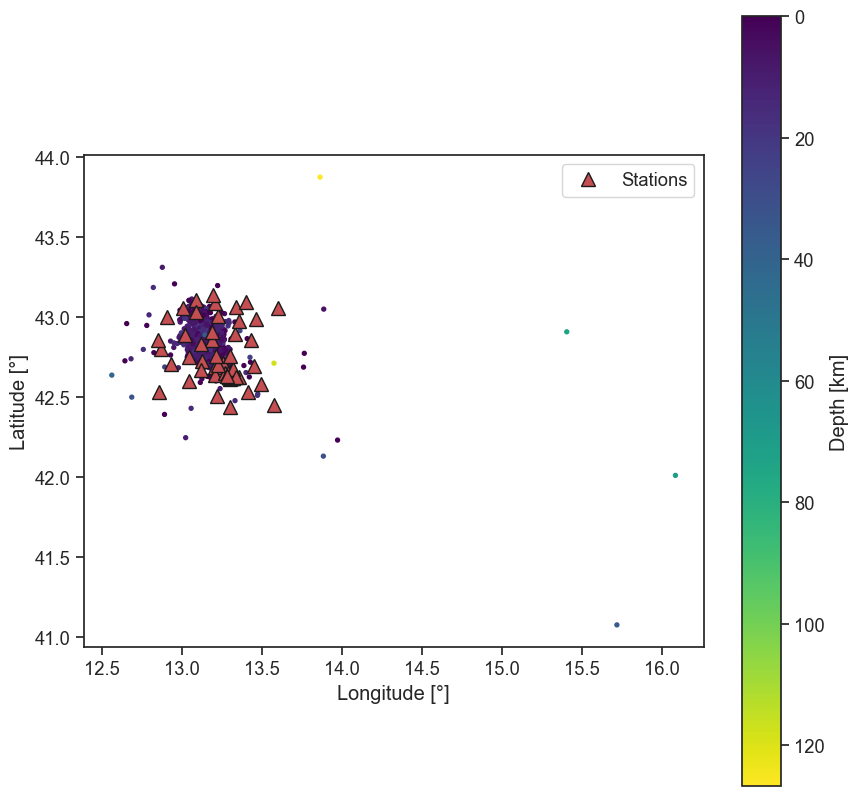

In [18]:
import matplotlib.pyplot as plt

# Creazione della figura
fig, ax = plt.subplots(figsize=(10, 10))
ax.set_aspect("equal")

# Scatter plot per i terremoti (colorati in base alla profondità)
cb = ax.scatter(
    catalog["longitude"], 
    catalog["latitude"], 
    c=catalog["z(km)"], 
    s=8, 
    cmap="viridis"
)

# Barra del colore per la profondità
cbar = fig.colorbar(cb)
cbar.ax.set_ylim(cbar.ax.get_ylim()[::-1])  # Inverto la scala della profondità
cbar.set_label("Depth [km]")

# Aggiunta delle stazioni (triangoli rossi)
ax.plot(
    station_df["longitude"], 
    station_df["latitude"], 
    "r^", 
    ms=10, 
    mew=1, 
    mec="k", 
    label="Stations"
)

# Etichette degli assi
ax.set_xlabel("Longitude [°]")
ax.set_ylabel("Latitude [°]")

# Aggiunta legenda
ax.legend()
output_file= os.path.join(output_folder_catalog, f"catalog_{year}_{training}.pdf")
plt.savefig(output_file, dpi=300, bbox_inches="tight")
# Mostrare il plot
plt.show()